# Spectrum Generation

We use the data to generate spectra for the incidence of particles on the detector

In [1]:
#Include modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from accelerate import *
from tqdm.notebook import tqdm

%matplotlib widget

In [2]:
# Read the files

# Parameters
run                     = 'run0'
runid                   = ''

# Find the files
foldername  = f'./data/{run}'
filenames   = [os.path.join(foldername,filename) for filename in os.listdir(foldername)]

# Print the number of files found
print(f'Found {len(filenames)} data files in {foldername}')

# Load the files in parallel using the method from accelerate
files = loadFiles([filename for filename in filenames if runid in filename])

Found 11 data files in ./data/run0


loadFile:   0%|          | 0/11 [00:00<?, ?it/s]

Cm244:   0%|          | 0/1 [00:00<?, ?it/s]

loadFile:   0%|          | 0/11 [00:00<?, ?it/s]

getEnergy:   0%|          | 0/11 [00:00<?, ?it/s]

smearEnergy:   0%|          | 0/11 [00:00<?, ?it/s]

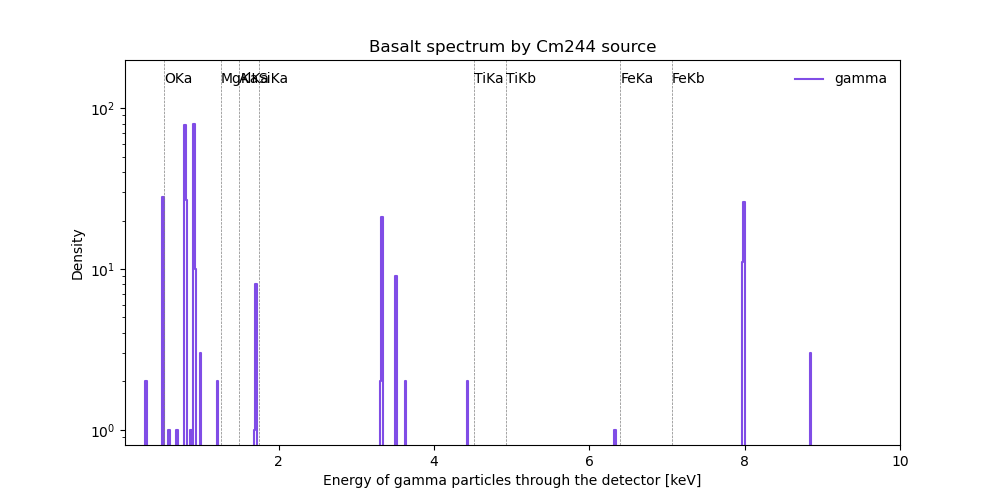

In [7]:
RUN_STRUCTURE = {
    'run0' : 'Cm244',
    # 'run1' : 'Fe55',
    # 'run2' : 'Cd109',
    # 'run3' : 'Co60',
    # 'run4' : 'Am241'
}

MATERIAL = {
    'name' : 'Basalt',
    'peaks' : {
        'FeKa' : 6.40,
        'FeKb' : 7.06,
        'TiKa' : 4.51,
        'TiKb' : 4.93,
        'SiKa' : 1.74,
        'AlKa' : 1.49,
        'MgKa' : 1.25,
        'OKa'  : 0.52,
    }
}

PARTICLE            = 'gamma'
STD                 = 0.08
particleEnergyList  = {}

# For all the simulation runs
pbar = tqdm(RUN_STRUCTURE,desc=list(RUN_STRUCTURE.values())[0])
for i,run in enumerate(pbar):
    # Collect their output files
    files = loadFiles([filename for filename in filenames if run in filename])

    # Extract the energy for each particle
    particleEnergyList[run] = getParticleEnergiesSmeared(files,size=STD)
    
    # Plot the spectrum
    if PARTICLE in particleEnergyList[run]: plotParticleHistogram(particleEnergyList[run],
        source          = RUN_STRUCTURE[run],
        PARTICLE        = PARTICLE,
        MATERIAL        = MATERIAL,
        SHOW_MATERIAL   = True,
        LIMS            = (0,10),
        MAX_PEAKS       = 0,
        NBINS           = 500,
        SAVE            = True)

    # Change the description of the progress bar to show the material processed
    try:
        pbar.set_description(list(RUN_STRUCTURE.values())[i+1])
    except:
        pass

In [5]:
print("The unique particles are:")
for run in particleEnergyList:
    print(f'{run}:',[[particle, len(particleEnergyList[run][particle])] for particle in particleEnergyList[run]])

The unique particles are:
run0: [['e-', 8069], ['alpha', 4393], ['gamma', 536]]
